# **Feature Description for Epileptic Seizure Detection using EEG**



Epileptic Seizure is an abnormally excessive neural activity that is characterized by uncontrolled convulsions and seizure. It is estimated to affect approximately 65 million people around the globe. Electroencephalograms(EEG) is a widely used tool for capturing the electrical activity of the brain during seizure. But the process of reviewing the EEG signal for seizure is both tidous and time consuming processes often hindered by lack of skilled technician. To add to the problem, the signal is characterized by low signal to noise ratios, the presence of artifacts, high variance among epleptic patients making the task challenging.
This underscores the need for automated epileptic seizure detection system.

There has been various innovative approaches in the effort to automate the manual process of reviewing EEG signals. Machine learning approaches has as gained some traction due to there ability to learn complex patterns form data, generalize well to new and unseen recordings, and there real time application as early warning system.


The overall processes of **automated epileptic seizure detection(AESD)** involves several stages from data acquisition to the final decision. The typical workflow for AESD includes:
- **Data acquisition**: involves collecting EEG data as a time series of voltage measurements over multiple channels.
- **Pre-processing**: the raw EEG recording is often infused with noise and artifacts. The pre-processing step involves filtering:
    - **Filtering**: to remove frequencies outside a certain range. It might include lowpass, highpass, bandpass, and notch filtering.
    - **Artifact Removal**: involves removing artifacts such as eye blink, muscle activity, power line artifacts from the EEG recording.
    - **Resampling**: involves adjusting the data's sampling rate. This ensures that data have consistant sampling rate.
- **Feature Extraction**: involves extracting relevant features that characterize the patterns associated with seizure. The common features include statistical features(mean, std, minimum, kurtosis), spectral features(spectral entropy, peak frequency, power spectral density), and time-frequency domain features(Wavelet transform coefficients, spectrogram).
- **Feature selection**: involves selecting the most informative features and helps to reduce the dimensionality of the data.
- **Seizure Classification/Detection/Prediction**: involves modeling the extracted features using different ML/DL algorithms, which are suited for different task, i.e, seizure classification, detection or prediction. This stage invovles varies steps including model selection(hyperparameter tuning), training, evaluation, and deployment.






This notebook explores the various features of EEG signal extracted from EEG recordings. These features highlights the different aspects of the seizure, helping us distinguish the background signal from the seizure. These features could be categorized based on the domain from which the features were calculated.
- **Time-Domain Features**: are featues computed from the raw EEG signal, which provide information about the signal characterstics over time.
- **Frequency Domain Features, a.k.a Spectral Features**: are features that describe the distribution of signal power across different frequency bands. Common spectral features include **power spectral density(PSD)**, **Spectral entropy** and **relative band power**.
- **Time-Frequency Domain Features**: captures how the signal's spectral content evolves over time. Techniques like **Short-Time Fourier Transform(STFT)** and **Continuous Wavelet Transform(CWT)** are used to extract these features.

## **Setup**

In [2]:
import os
import sys
import mne
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [3]:
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(ROOT_PATH)

from utils.preprocessing.convert_montage import convert_to_bipolar
from utils.plots import plot_eeg_lbl, plot_eeg_tse

from utils import read_lbl_file
from utils.data_loader import return_data_segment

from utils.features.time_domain import *
from utils.features.frequency_domain import *
from utils.features.time_frequency_domain import *


## **Helper Functions**

In [ ]:
# Remove files with only the background class that were unzipped.
train_paths = []
tse_paths = glob(f'{ROOT_PATH}/data/external/train/**/**/**/**/*.tse')

for path in tqdm(tse_paths):
    tse_label_df = pd.read_csv(path, sep=' ', header=0, names=['start time(s)', 'stop time(s)', 'multi class code', 'probability'])
    if (tse_label_df['multi class code'].unique()).all()== 'bckg':
        continue
    else: 
        train_paths.append(path.replace('.tse', '.edf').replace('\\', '/'))

random.seed(45)
random.shuffle(train_paths)

with open(f'{ROOT_PATH}/data/processed/seizure_files.txt', 'a+') as f:
    for train_path in train_paths:
        f.write(f'{train_path}\n')

In [ ]:
# edf_paths = ['/content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/01_tcp_ar/004/00000492/s003_2003_07_18/00000492_s003_t000.edf']
import random
edf_paths = glob('/content/the-tuh-eeg-seizure-corpus-tusz-v152/edf/train/**/**/**/**/*.edf')
random.seed(45)
random.shuffle(edf_paths)


error_path = []
for edf_path in edf_paths[10: 30]:
    print(edf_path)
    eeg_segments, segment_labels, sfreq = return_data_segment(edf_path, segment_duration=1.0, step_size=1.0)
    file_name = edf_path.split('/')[-1].split('.')[0]

    eeg_segment_features = []
    for eeg_segment in tqdm(eeg_segments):

        stat_feature = StatisticalFeatures(eeg_segment)
        amp_features = AmplitudeFeatures(eeg_segment)
        hjorth_param = HjorthParameters(eeg_segment)
        entr_features = EntropyFeatures(eeg_segment)

        spectral_features = SpectralFeatures(eeg_segment, sample_rate=sfreq)

        time_domain_features = [
            stat_feature.mean(), stat_feature.std_deviation(), stat_feature.variance(),
            stat_feature.mode(), stat_feature.median(), stat_feature.skewness(),
            stat_feature.kurtosis(), stat_feature.minimum(), stat_feature.maximum(),
            stat_feature.coefficient_of_variation(), *stat_feature.quartiles(), stat_feature.inter_quartile_range(),

            amp_features.energy(), amp_features.average_power(), amp_features.root_mean_squared(),
            amp_features.line_length(), amp_features.zero_crossings(), amp_features.local_extrema(),

            hjorth_param.activity(), hjorth_param.mobility(), hjorth_param.complexity(),

            entr_features.shannon_entropy(),
            #entr_features.approximate_entropy(m=2, r=0.2),
            entr_features.sample_entropy(m=2, r=0.2) , entr_features.permutation_entropy(m=3),
            entr_features.weighted_permutation_entropy(m=3), entr_features.fuzzy_entropy(m=2, r=0.2),
            entr_features.distribution_entropy(num_bins=10), entr_features.svd_entropy(num_components=5)
        ]

        frequency_features = [
            spectral_features.mean(), spectral_features.variance(), spectral_features.skewness(),
            spectral_features.kurt(), spectral_features.energy(),
            spectral_features.frequency_bands(band_ranges=[(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 50)]),
            spectral_features.peak_frequency(), spectral_features.frequency_centroid(),
            spectral_features.bandwidth(), spectral_features.spectral_entropy(),
            spectral_features.cross_frequency_ratios(band_ranges=[(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 50)])

        ]

        eeg_segment_features.append(time_domain_features + frequency_features)
    eeg_segment_features = np.array(eeg_segment_features)
    np.savez_compressed(f'/content/extracted_features/{file_name}_feat', eeg_segment_features)
    np.savez_compressed(f'/content/extracted_features/{file_name}_lbl', segment_labels)

    edf_paths.pop(edf_paths.index(edf_path))

In [18]:
import os
import sys
import mne
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt


from utils import read_lbl_file
from utils.preprocessing.convert_montage import convert_to_bipolar


def plot_eeg_features(eeg_path, to_bipolar=True, seiz_offset_time=10,  plot_height=2, plot_width=190, save_dst=None):
    if to_bipolar:
        eeg_data = convert_to_bipolar(eeg_path)
    else:
        eeg_data = mne.io.read_raw_edf(eeg_path, verbose=False)
    sfreq = eeg_data.info['sfreq']

    lbl_path = eeg_path.replace('.edf', '.lbl_bi')
    lbl_dicts = read_lbl_file(lbl_path)

    # Highlight seizure region
    for lbl_key in lbl_dicts:
        for lbl_val in lbl_dicts[lbl_key]:
            (start_time, stop_time), cls_code = lbl_val
            if cls_code == 'seiz':
                seiz_start_idx, seiz_stop_idx = int(start_time * sfreq), int(stop_time * sfreq)
                offset_from_seiz = int(seiz_offset_time * sfreq)

                eeg_plot_data = eeg_data.get_data()[lbl_key, seiz_start_idx-offset_from_seiz: seiz_stop_idx+offset_from_seiz]
                # eeg_plot_data = eeg_data.get_data()[lbl_key:seiz_start_idx-offset_from_seiz: seiz_stop_idx+offset_from_seiz]

                plt.figure(figsize=(plot_width, plot_height))
                plt.yticks([])

                plt.plot(eeg_plot_data)
                # Add horizontal lines at y=0

                plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
                plt.axvspan(seiz_start_idx, seiz_stop_idx, color='red', alpha=0.3)


                # Add vertical lines at every second
                for sec in range(1, len(eeg_plot_data)):
                    if sec % sfreq == 0:
                        plt.axvline(x=sec, color='gray', linestyle='--', linewidth=0.5)

                plt.xlabel('Samples')
                plt.tight_layout()
                plt.show()

4356


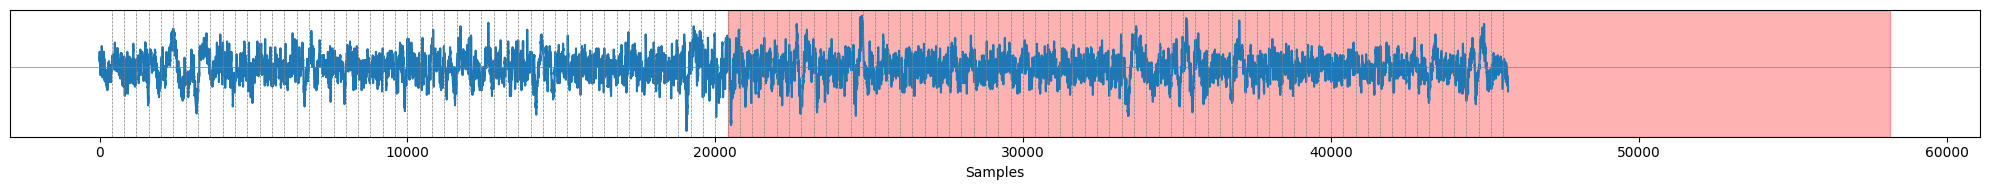

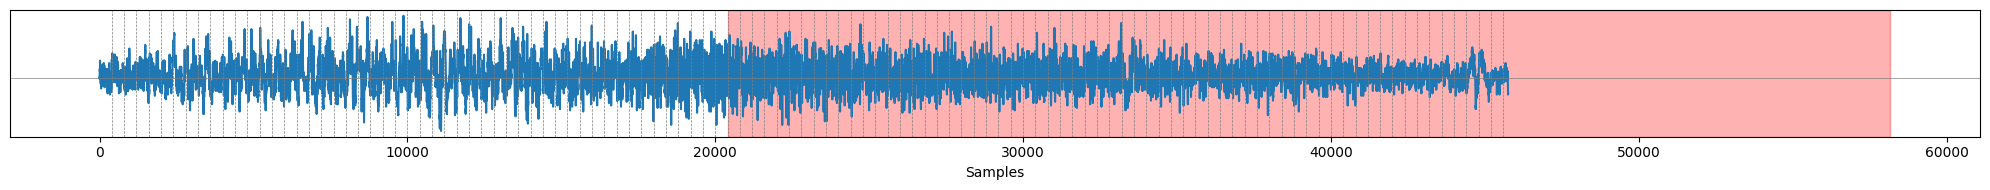

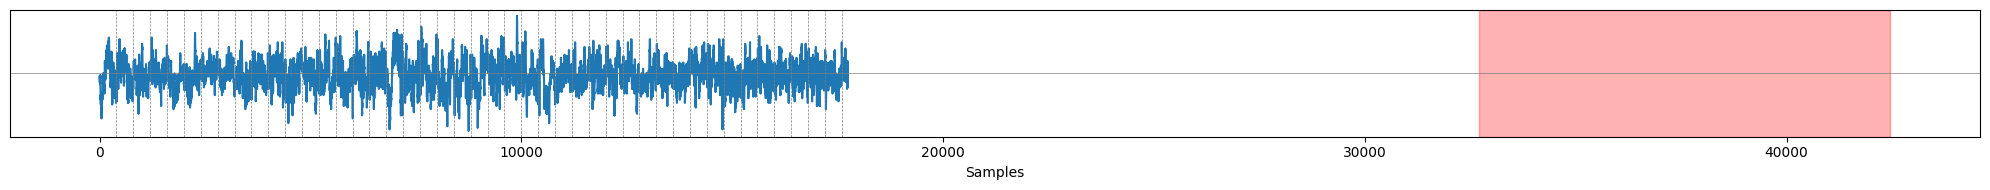

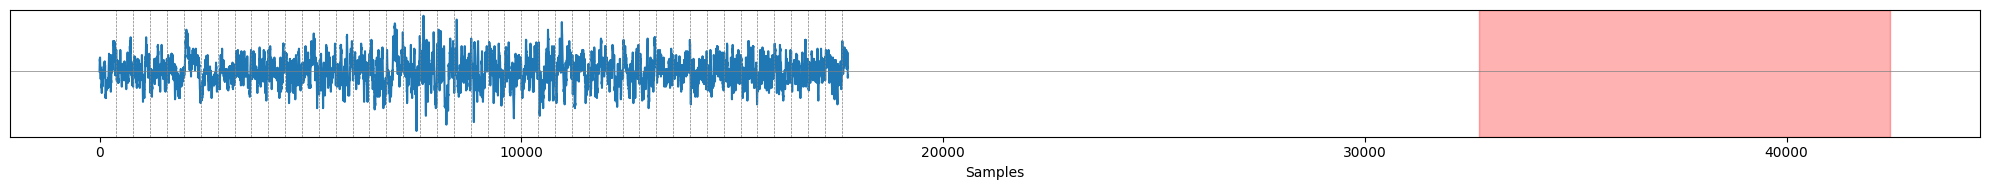

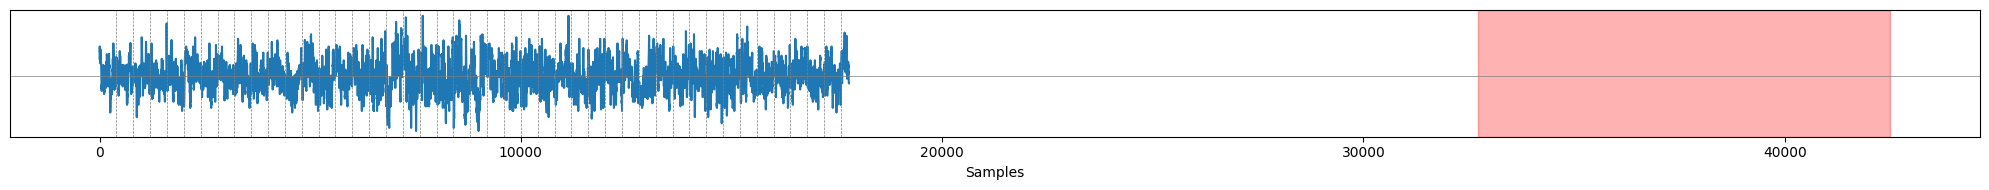

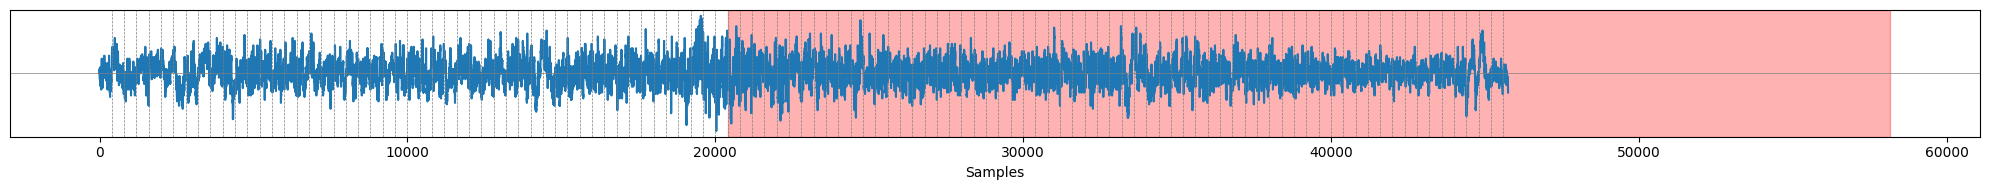

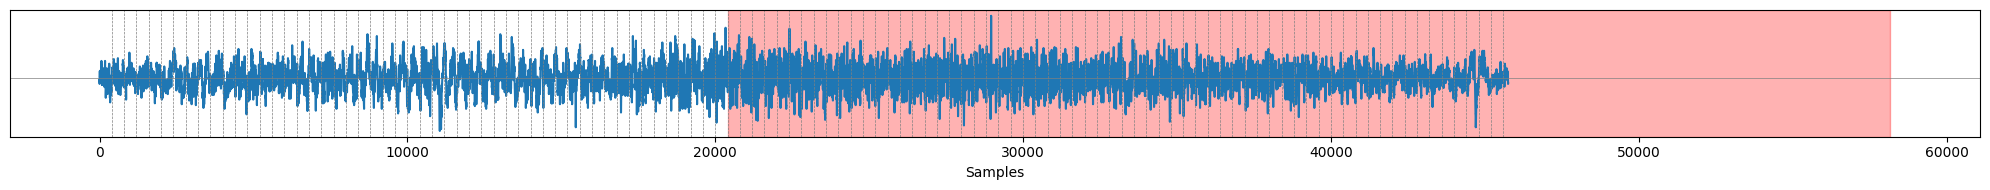

In [19]:

edf_paths = glob(f'{ROOT_PATH}/data/external/train/**/**/**/**/*.edf')
rand_idx = random.randint(0, len(edf_paths))
eeg_path = edf_paths[rand_idx]
print(rand_idx)

plot_eeg_features(eeg_path, to_bipolar=True, plot_height=2, plot_width=20, save_dst=None)
# plot_eeg_lbl(eeg_path, to_bipolar=True, plot_height=2, plot_width=190, save_dst=None)


## **Time-Domain Features**

Time-domain features are class of features which are directly computed form the EEG recording and characterize various states of brain activity across time. These featues illustrate the temporal characterstics of the EEG signal. Some of the common time-domain featues includes:

### **Statistical Features**
Statistical features in time domain conveys the statistical properites of signal amplitude distribution over time. These features helps quantify varies EEG signal's temporal behavior. Some of the statistical features includes:


- **Mean**:
    - The mean of EEG signal represent the average amplitude of the EEG signal over a specified time window.
    - The mean amplitude of the EEG signal is typically higher during seizure compared to the background (normal brain recording). Seizure-related spikes are indicated by elevated mean values.

- **Variance and Standard Deviation**
    - The variance and standard deviation of EEG signal dispersion or variability. It measures the spread of EEG signal amplitudes around the mean.
    - Seizure activity often results in increased signal variability, leading to higher variance and standard deviation.




- **Skewness and Kurtosis**:

    - Skewness easures the asymmetry of the EEG signal's amplitude distribution where positive skewness indicates a right-tailed distribution, while negative skewness indicates a tail on the left side.
    - A distribution can have right (or positive), left (or negative), or zero skewness. Asymmetry in the distribution makes the left and right side are not mirror images. 
    - Kurtosis describes the shape of the EEG signal's amplitude distribution.
    - High kurtosis suggests a distribution with heavy tails and more extreme values.
    - Seizures can introduce asymmetry and non-Gaussian behavior into the EEG signal.
    - Positive skewness and high kurtosis values may suggest the presence of seizure-related spikes.


- **Coefficient of Variation (CV)**
    - The coefficient of variation is the ratio of the standard deviation to the mean which quantifies the relative variability of the signal.
    - An increased CV indicates a greater relative variability in the signal, which can be indicative of seizure-related events.

- **Interquartile Range (IQR)**:
    - Interquartile range represents the range between the 25th and 75th percentiles of the signal's amplitude distribution.
    - It provides a measure of the central spread of the data.
    - Seizures often lead to larger peak-to-peak signal variations, resulting in an expanded range and IQR values.

- **Minimum and Maximum**

    - These features provide insights into the extreme values and amplitude fluctuations within the EEG signal
    - During a seizure, the EEG often exhibits higher-amplitude spikes or rhythmic patterns. The minimum and maximum values can be relatively higher during seizures, reflecting these elevated amplitudes.

- **Range**

    - Range represents the difference between the maximum and minimum values of the EEG signal.
    - It provides a measure of the signal's dynamic range.

### **Entropy Features**

Entropy features are derived from the concept of entropy, which quantifies the amount of information, randomness, or disorder in a signal. In EEG signal analysis, entropy features are used to assess the complexity or irregularity of the signal. There are various entropy measures, each providing different insights into the signal's characteristics. Here are some common entropy features used in EEG analysis:

- **Shannon Entropy**

    - Shannon entropy measures the average uncertainty or information content in a signal which quantifies the signal's overall randomness or disorder.
    - High Shannon entropy values suggest greater unpredictability in the signal.

- **Approximate Entropy (ApEn)**

    - Approximate Entropy quantifies the similarity between patterns of data points within the signal.
    - It is often used to detect changes or irregularities in the signal.
    - Lower ApEn values indicate greater regularity or predictability.

- **Approximate Entropy (ApEn)**

    - Approximate Entropy quantifies the similarity between patterns of data points within the signal.
    - It is often used to detect changes or irregularities in the signal.
    - Lower ApEn values indicate greater regularity or predictability.

- **Sample Entropy (SampEn)**

    - Similar to ApEn, SampEn assesses the complexity and regularity of the signal.
    - It is less sensitive to data length and noise than ApEn.
    - Lower SampEn values suggest a more regular signal.

- **Permutation Entropy**

    - Permutation entropy measures the likelihood of permutations of the data within a specified embedding dimension.
    - It assesses the degree of disorder or randomness in the signal.
    - Higher permutation entropy values indicate increased randomness.

- **Weighted Permutation Entropy**

- **Fuzzy Entropy**

- **Distribution Entropy**

## **Other Features**

- **Energy**

- **Root Mean Square (RMS)**

    - Computes the square root of the mean of the squared signal values.
    - It provides a measure of signal magnitude.

- **Average Power**

- **Zero-Crossing Rate**

    - Zero-Crossing Rate is the number of times the EEG signal crosses the zero axis within a given time interval. It can indicate the rate of signal oscillation.
    - Seizure activity can result in rapid and frequent changes in the EEG signal, leading to an increased zero-crossing rate.

- **Crest Factor**

    - Represents the ratio of the peak value to the RMS value of the signal.
    - It can provide information about signal peakiness.

- **Line Length**

    - Represents the sum of the absolute differences between consecutive data points.
    - It quantifies the signal's total waveform length.

- **Local Extrema**

- **Hjorth Parameters**